In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
DATA_PATH = '/content/drive/MyDrive/ML&PR/'
IMAGES_PATH_1 = DATA_PATH + 'HAM10000_images_part_1/'
IMAGES_PATH_2 = DATA_PATH + 'HAM10000_images_part_2/'
METADATA_PATH = DATA_PATH + 'HAM10000_metadata.csv'

In [6]:
metadata = pd.read_csv(METADATA_PATH)

In [7]:
print("Dataset shape:", metadata.shape)

Dataset shape: (10015, 7)


In [8]:
print("Columns: " + str(list(metadata.columns)))

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


In [9]:
print("\nFirst 5 rows:")
display(metadata.head())


First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [10]:
print("=== DATASET OVERVIEW ===")
print("Total number of samples: " + str(len(metadata)))
print("Number of features: " + str(metadata.shape[1]))
print("\n=== COLUMN INFORMATION ===")
metadata.info()

=== DATASET OVERVIEW ===
Total number of samples: 10015
Number of features: 7

=== COLUMN INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [11]:
print("\n=== MISSING VALUES ===")
missing_data = metadata.isnull().sum()
missing_df = pd.DataFrame({
    'Missing Count': missing_data
})
print(missing_df[missing_df['Missing Count'] > 0])


=== MISSING VALUES ===
     Missing Count
age             57


In [12]:
print("\n=== BASIC STATISTICS ===")
print(metadata.describe(include='all'))


=== BASIC STATISTICS ===
          lesion_id      image_id     dx dx_type          age    sex  \
count         10015         10015  10015   10015  9958.000000  10015   
unique         7470         10015      7       4          NaN      3   
top     HAM_0000835  ISIC_0032258     nv   histo          NaN   male   
freq              6             1   6705    5340          NaN   5406   
mean            NaN           NaN    NaN     NaN    51.863828    NaN   
std             NaN           NaN    NaN     NaN    16.968614    NaN   
min             NaN           NaN    NaN     NaN     0.000000    NaN   
25%             NaN           NaN    NaN     NaN    40.000000    NaN   
50%             NaN           NaN    NaN     NaN    50.000000    NaN   
75%             NaN           NaN    NaN     NaN    65.000000    NaN   
max             NaN           NaN    NaN     NaN    85.000000    NaN   

       localization  
count         10015  
unique           15  
top            back  
freq           2192  

In [13]:
# Count of each diagnosis
print("=== DIAGNOSIS DISTRIBUTION ANALYSIS ===")
diagnosis_counts = metadata['dx'].value_counts()
print("Diagnosis counts:")
print(diagnosis_counts)

=== DIAGNOSIS DISTRIBUTION ANALYSIS ===
Diagnosis counts:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [14]:
# Diagnosis mapping created for better visualization and interpretation
diagnosis_mapping = {
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular Lesions'
}

# Adding full diagnosis names
metadata['diagnosis_full'] = metadata['dx'].map(diagnosis_mapping)

Visualization of Diagnosis and it's distribution

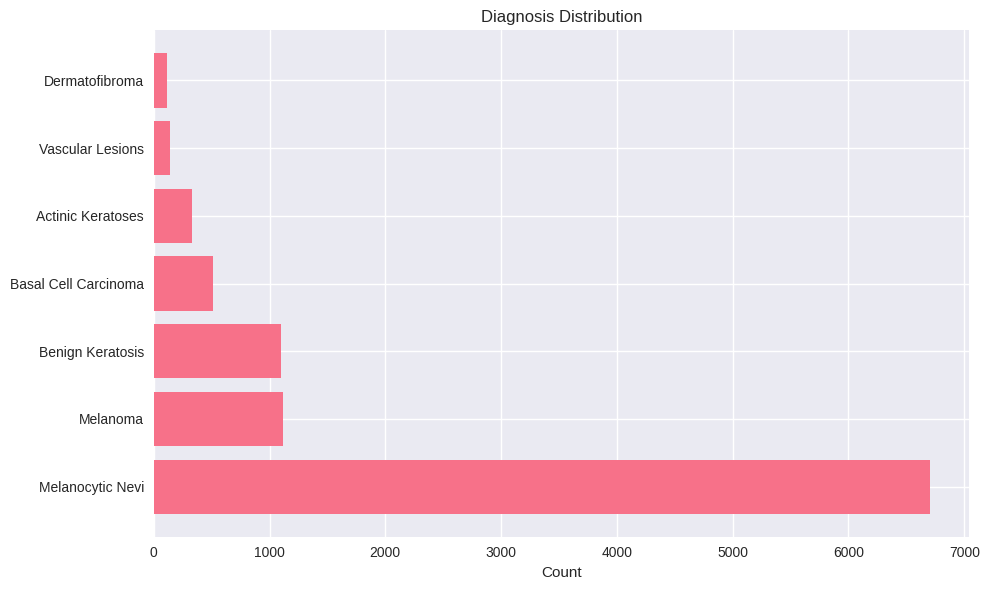

In [15]:
# Visualization - Diagnosis Distribution
# Horizontal Bar Chart
diagnosis_full_counts = metadata['diagnosis_full'].value_counts()

plt.figure(figsize=(10, 6))
plt.barh(range(len(diagnosis_full_counts)), diagnosis_full_counts.values)
plt.yticks(range(len(diagnosis_full_counts)), diagnosis_full_counts.index)
plt.title('Diagnosis Distribution')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

In [16]:
# Check for class imbalance
print(f"\nClass Imbalance Analysis:")
print(f"Most common class: {diagnosis_counts.index[0]} ({diagnosis_counts.iloc[0]} samples)")
print(f"Least common class: {diagnosis_counts.index[-1]} ({diagnosis_counts.iloc[-1]} samples)")
print(f"Imbalance ratio: {diagnosis_counts.iloc[0] / diagnosis_counts.iloc[-1]:.2f}:1")


Class Imbalance Analysis:
Most common class: nv (6705 samples)
Least common class: df (115 samples)
Imbalance ratio: 58.30:1


In [17]:
# Cell 9: Diagnosis Type (dx_type) Analysis
print("=== DIAGNOSIS TYPE (dx_type) ANALYSIS ===")

# Analyze dx_type distribution
print("Diagnosis Type Distribution:")
dx_type_counts = metadata['dx_type'].value_counts()
print(dx_type_counts)

=== DIAGNOSIS TYPE (dx_type) ANALYSIS ===
Diagnosis Type Distribution:
dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64


In [18]:
# Created dx_type mapping for better understanding
dx_type_mapping = {
    'histo': 'Histopathology',
    'follow_up': 'Follow-up',
    'consensus': 'Expert Consensus',
    'confocal': 'Confocal Microscopy'
}
# Add full dx_type names if they exist in the data
metadata['dx_type_full'] = metadata['dx_type'].map(dx_type_mapping).fillna(metadata['dx_type'])

In [19]:
print(f"\nDiagnosis Type Meanings:")
for short, full in dx_type_mapping.items():
    if short in metadata['dx_type'].values:
        count = (metadata['dx_type'] == short).sum()
        print(f"  {short}: {full} ({count} cases)")


Diagnosis Type Meanings:
  histo: Histopathology (5340 cases)
  follow_up: Follow-up (3704 cases)
  consensus: Expert Consensus (902 cases)
  confocal: Confocal Microscopy (69 cases)


In [20]:
# Analyze dx_type vs dx relationship
print(f"\n=== DIAGNOSIS TYPE vs DIAGNOSIS ANALYSIS ===")
dx_vs_dx_type = pd.crosstab(metadata['dx'], metadata['dx_type'])
print("Cross-tabulation of Diagnosis vs Diagnosis Type:")
print(dx_vs_dx_type)


=== DIAGNOSIS TYPE vs DIAGNOSIS ANALYSIS ===
Cross-tabulation of Diagnosis vs Diagnosis Type:
dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    327
bcc             0          0          0    514
bkl            69        264          0    766
df              0         60          0     55
mel             0          0          0   1113
nv              0        503       3704   2498
vasc            0         75          0     67


In [21]:
# Calculate percentages within each diagnosis
dx_vs_dx_type_pct = pd.crosstab(metadata['dx'], metadata['dx_type'], normalize='index') * 100
print(f"\nPercentage distribution of diagnosis types within each diagnosis:")
print(dx_vs_dx_type_pct.round(1))


Percentage distribution of diagnosis types within each diagnosis:
dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0        0.0        0.0  100.0
bcc           0.0        0.0        0.0  100.0
bkl           6.3       24.0        0.0   69.7
df            0.0       52.2        0.0   47.8
mel           0.0        0.0        0.0  100.0
nv            0.0        7.5       55.2   37.3
vasc          0.0       52.8        0.0   47.2


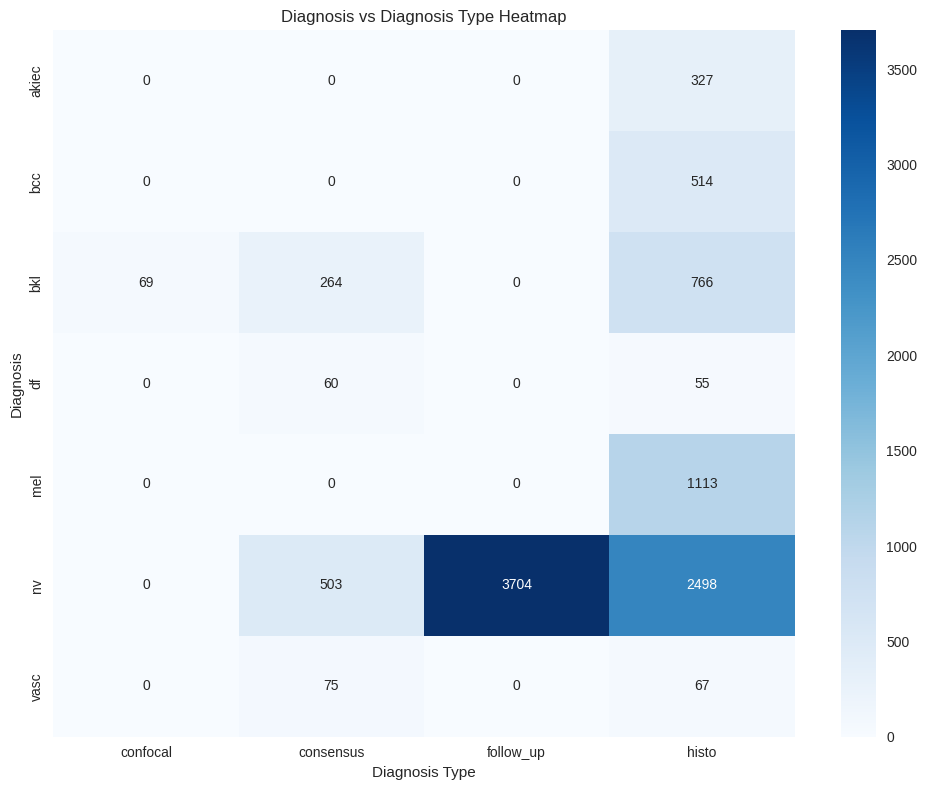

In [22]:
# Visualize dx_type analysis
plt.figure(figsize=(10, 8))
sns.heatmap(dx_vs_dx_type, annot=True, fmt='d', cmap='Blues')
plt.title('Diagnosis vs Diagnosis Type Heatmap')
plt.xlabel('Diagnosis Type')
plt.ylabel('Diagnosis')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

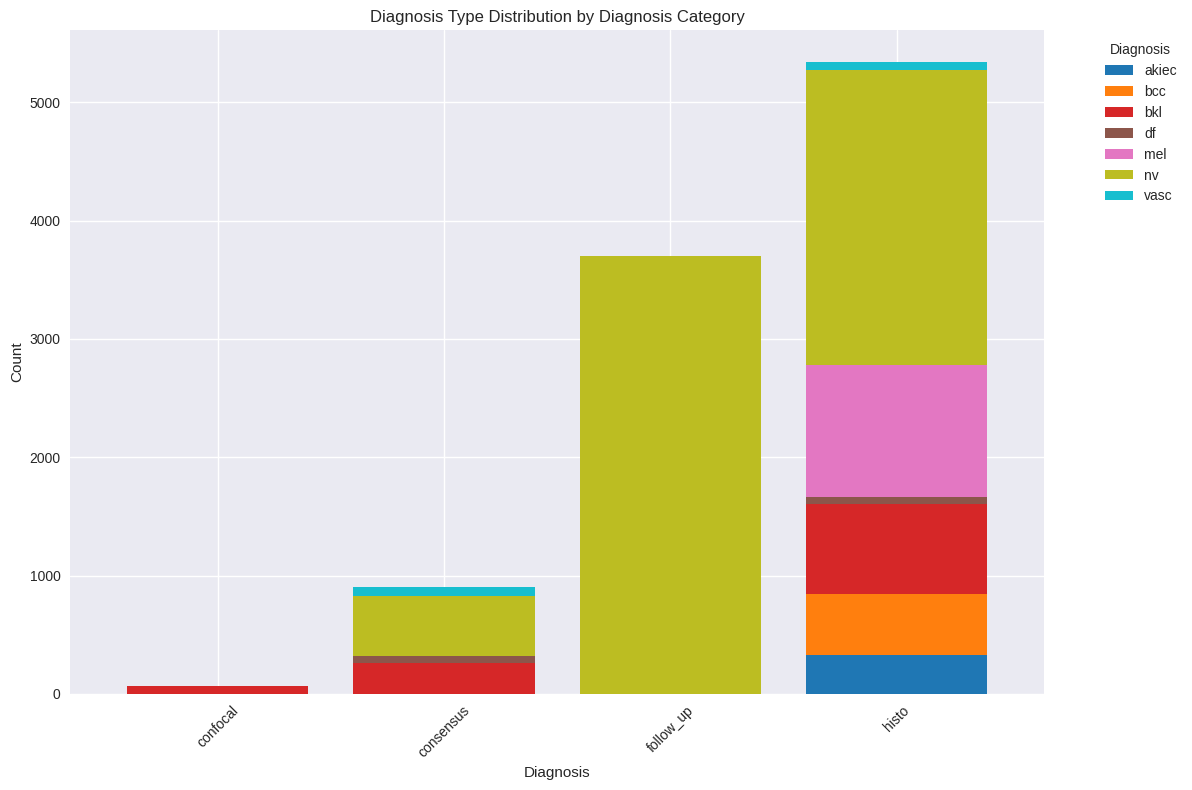

In [23]:
plt.figure(figsize=(12, 8))
dx_vs_dx_type.T.plot(kind='bar', stacked=True, colormap='tab10', width=0.8)
plt.title('Diagnosis Type Distribution by Diagnosis Category')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Reliability analysis based on dx_type
print(f"\n=== DIAGNOSIS RELIABILITY ANALYSIS ===")
print("Reliability ranking (from most to least reliable):")
reliability_order = ['histo', 'confocal', 'consensus', 'follow_up']
for i, dx_type in enumerate(reliability_order, 1):
    if dx_type in dx_type_counts.index:
        count = dx_type_counts[dx_type]
        reliability_desc = dx_type_mapping.get(dx_type, dx_type)
        print(f"{i}. {reliability_desc} ({dx_type}): {count} cases")

# Identify which diagnoses have the most reliable confirmation
print(f"\nMost reliably confirmed diagnoses (histopathology %):")
if 'histo' in metadata['dx_type'].values:
    histo_by_dx = metadata[metadata['dx_type'] == 'histo']['dx'].value_counts()
    total_by_dx = metadata['dx'].value_counts()
    histo_percentage = (histo_by_dx / total_by_dx * 100).fillna(0).sort_values(ascending=False)
    for dx, pct in histo_percentage.items():
        dx_name = diagnosis_mapping.get(dx, dx)
        print(f"  {dx_name} ({dx}): {pct:.1f}% histologically confirmed")


=== DIAGNOSIS RELIABILITY ANALYSIS ===
Reliability ranking (from most to least reliable):
1. Histopathology (histo): 5340 cases
2. Confocal Microscopy (confocal): 69 cases
3. Expert Consensus (consensus): 902 cases
4. Follow-up (follow_up): 3704 cases

Most reliably confirmed diagnoses (histopathology %):
  Melanoma (mel): 100.0% histologically confirmed
  Actinic Keratoses (akiec): 100.0% histologically confirmed
  Basal Cell Carcinoma (bcc): 100.0% histologically confirmed
  Benign Keratosis (bkl): 69.7% histologically confirmed
  Dermatofibroma (df): 47.8% histologically confirmed
  Vascular Lesions (vasc): 47.2% histologically confirmed
  Melanocytic Nevi (nv): 37.3% histologically confirmed


In [25]:
# Patient Demographics Analysis
print("=== PATIENT DEMOGRAPHICS ANALYSIS ===")

# Age analysis
print("Age Statistics:")
print(metadata['age'].describe())

=== PATIENT DEMOGRAPHICS ANALYSIS ===
Age Statistics:
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64


In [26]:
# Sex distribution
print(f"\nSex Distribution:")
sex_counts = metadata['sex'].value_counts()
print(sex_counts)
print(f"Sex percentages:")
print((sex_counts / len(metadata) * 100).round(2))


Sex Distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64
Sex percentages:
sex
male       53.98
female     45.45
unknown     0.57
Name: count, dtype: float64


In [27]:
# Localization analysis
print(f"\nBody Location Distribution:")
location_counts = metadata['localization'].value_counts()
print(location_counts)


Body Location Distribution:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


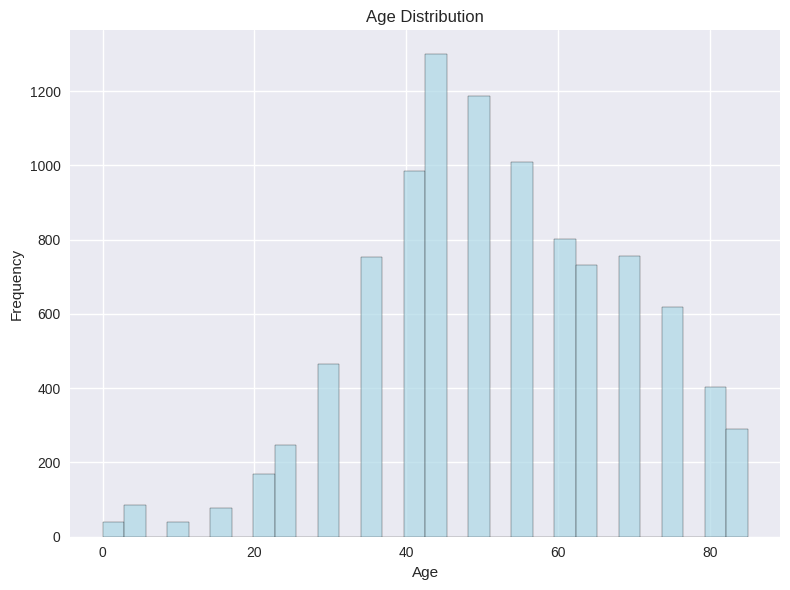

In [28]:
# Age distribution
plt.figure(figsize=(8, 6))
plt.hist(metadata['age'].dropna(), bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

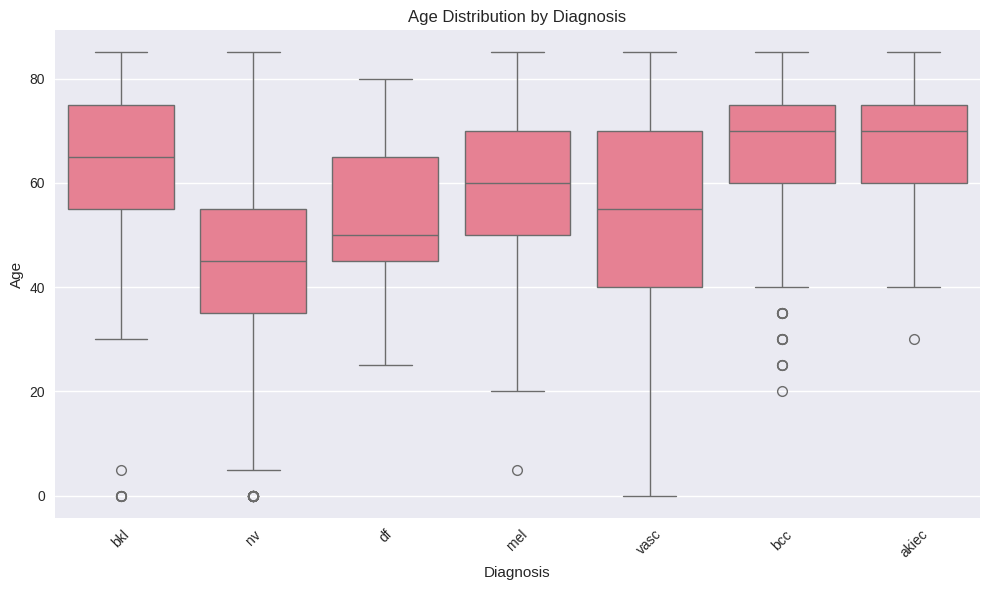

In [29]:
# Age distribution by Diagnosis
plt.figure(figsize=(10, 6))
sns.boxplot(data=metadata, x='dx', y='age')
plt.title('Age Distribution by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

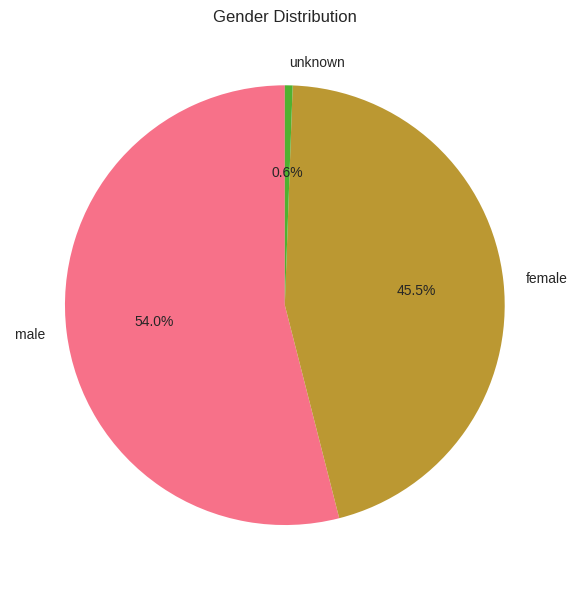

In [30]:
# Gender distribution
plt.figure(figsize=(6, 6))
sex_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.ylabel('')  # Hide ylabel for pie chart
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

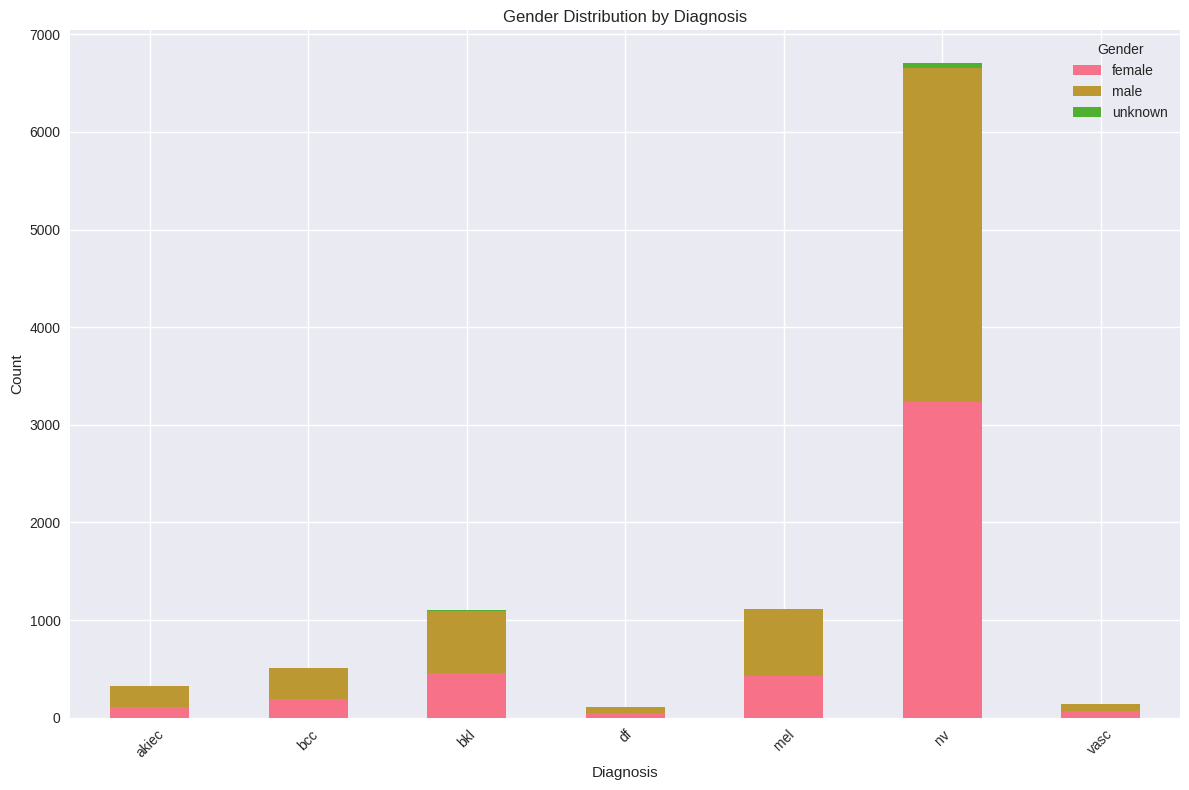

In [31]:
# Step 2: Group and count by diagnosis and gender
sex_diagnosis = metadata.groupby(['dx', 'sex']).size().unstack()

# Step 3: Plot
plt.figure(figsize=(10, 6))
sex_diagnosis.plot(kind='bar', stacked=True)
plt.title('Gender Distribution by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


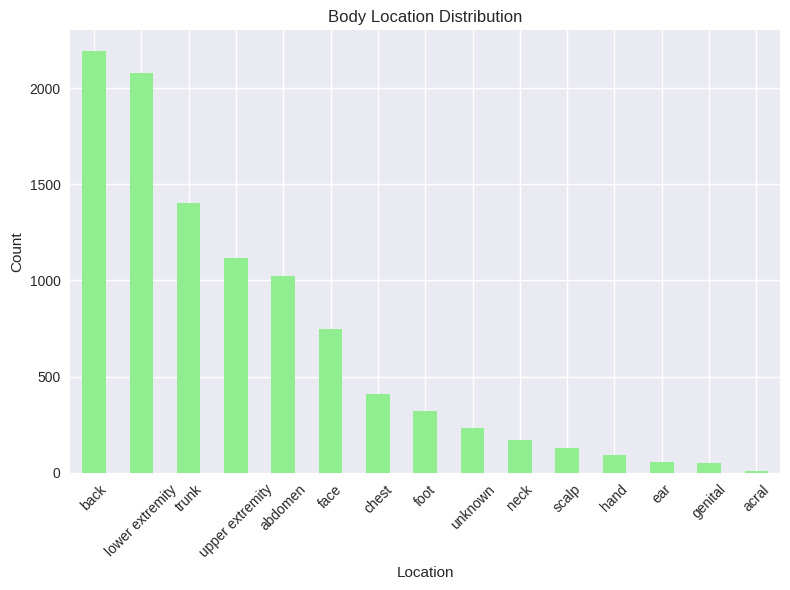

In [32]:
# Bar chart
plt.figure(figsize=(8, 6))
location_counts.plot(kind='bar', color='lightgreen')
plt.title('Body Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Cell 10: Advanced Demographic Analysis
print("=== ADVANCED DEMOGRAPHIC ANALYSIS ===")

# Define age group categorization using explicit ranges
def categorize_age(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 30:
        return 'Young (0-29)'
    elif age >= 30 and age < 50:
        return 'Middle-aged (30-49)'
    elif age >= 50 and age < 70:
        return 'Older (50-69)'
    else:  # age >= 70
        return 'Elderly (70+)'

# Apply to dataset
metadata['age_group'] = metadata['age'].apply(categorize_age)

# Print distribution
print("Age Group Distribution:")
print(metadata['age_group'].value_counts())

=== ADVANCED DEMOGRAPHIC ANALYSIS ===
Age Group Distribution:
age_group
Older (50-69)          3730
Middle-aged (30-49)    3501
Elderly (70+)          2068
Young (0-29)            659
Unknown                  57
Name: count, dtype: int64


In [34]:
# Cross-tabulation analysis
print("\n=== CROSS-TABULATION ANALYSIS ===")
print("Diagnosis by Age Group:")
diagnosis_age = pd.crosstab(metadata['dx'], metadata['age_group'])
print(diagnosis_age)


=== CROSS-TABULATION ANALYSIS ===
Diagnosis by Age Group:
age_group  Elderly (70+)  Middle-aged (30-49)  Older (50-69)  Unknown  \
dx                                                                      
akiec                165                   20            142        0   
bcc                  286                   58            166        0   
bkl                  527                  135            421       10   
df                    16                   39             58        0   
mel                  418                  193            477        2   
nv                   615                 3024           2419       45   
vasc                  41                   32             47        0   

age_group  Young (0-29)  
dx                       
akiec                 0  
bcc                   4  
bkl                   6  
df                    2  
mel                  23  
nv                  602  
vasc                 22  


In [35]:
print("\nDiagnosis by Gender:")
diagnosis_gender = pd.crosstab(metadata['dx'], metadata['sex'])
print(diagnosis_gender)


Diagnosis by Gender:
sex    female  male  unknown
dx                          
akiec     106   221        0
bcc       197   317        0
bkl       463   626       10
df         52    63        0
mel       424   689        0
nv       3237  3421       47
vasc       73    69        0


In [36]:
print("\nDiagnosis by Location:")
diagnosis_location = pd.crosstab(metadata['dx'], metadata['localization'])
print(diagnosis_location)


Diagnosis by Location:
localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               5      0    29     12    3   113     0        0    13   
bcc                18      0   186     47    0   101     4        0     2   
bkl                42      0   202     74    6   319     1        2    14   
df                  4      0     2      0    0     0     2        1     0   
mel                66      0   324     68   17   104    28        0     1   
nv                860      7  1427    200   30   100   284       45    55   
vasc               27      0    22      6    0     8     0        0     5   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      65    10     14      1        0               62  
bcc                        58    14     19     1

In [37]:
print("\nDiagnosis by Diagnosis Type:")
diagnosis_dx_type = pd.crosstab(metadata['dx'], metadata['dx_type'])
print(diagnosis_dx_type)


Diagnosis by Diagnosis Type:
dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    327
bcc             0          0          0    514
bkl            69        264          0    766
df              0         60          0     55
mel             0          0          0   1113
nv              0        503       3704   2498
vasc            0         75          0     67


=== CORRELATION AND STATISTICAL ANALYSIS ===


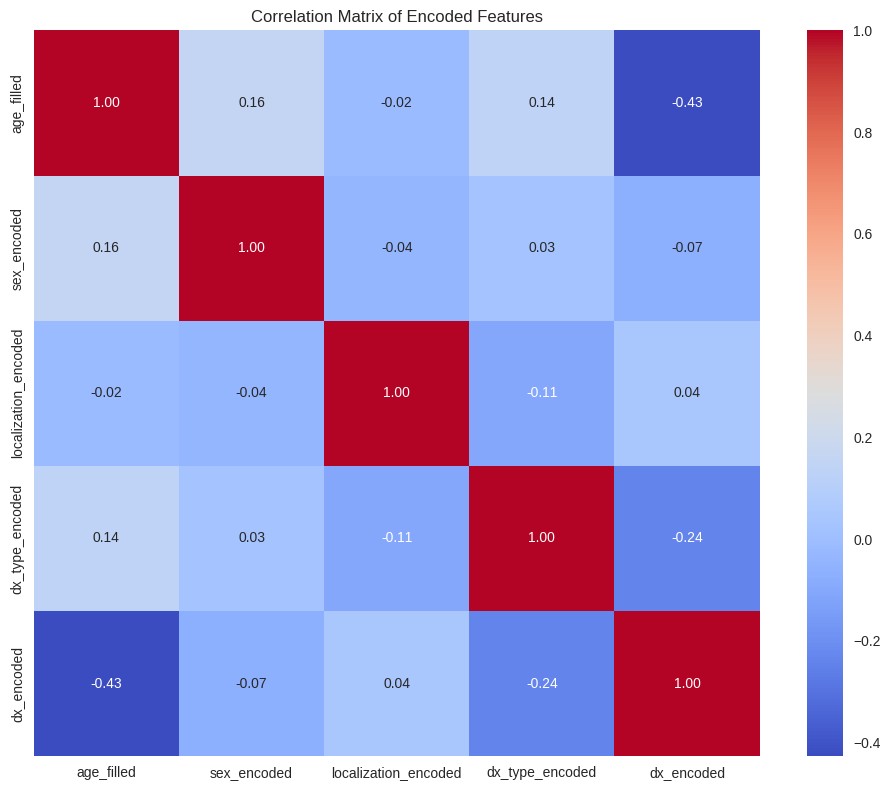

Correlation Analysis:
                      age_filled  sex_encoded  localization_encoded  \
age_filled              1.000000     0.163171             -0.015514   
sex_encoded             0.163171     1.000000             -0.039845   
localization_encoded   -0.015514    -0.039845              1.000000   
dx_type_encoded         0.140546     0.025853             -0.105914   
dx_encoded             -0.426755    -0.073130              0.042260   

                      dx_type_encoded  dx_encoded  
age_filled                   0.140546   -0.426755  
sex_encoded                  0.025853   -0.073130  
localization_encoded        -0.105914    0.042260  
dx_type_encoded              1.000000   -0.238336  
dx_encoded                  -0.238336    1.000000  


In [38]:
from sklearn.preprocessing import LabelEncoder
print("=== CORRELATION AND STATISTICAL ANALYSIS ===")

# Copy for encoding
metadata_encoded = metadata.copy()

# Fill missing categorical values
metadata_encoded['sex'] = metadata_encoded['sex'].fillna('Unknown')

# Encode categorical variables
label_encoders = {}
for col in ['dx', 'sex', 'localization', 'dx_type']:
    le = LabelEncoder()
    metadata_encoded[f'{col}_encoded'] = le.fit_transform(metadata_encoded[col])
    label_encoders[col] = le  # store encoders in case you need inverse_transform later

# Fill missing age
metadata_encoded['age_filled'] = metadata_encoded['age'].fillna(metadata_encoded['age'].median())

# Correlation matrix
features = ['age_filled', 'sex_encoded', 'localization_encoded', 'dx_type_encoded', 'dx_encoded']
corr_matrix = metadata_encoded[features].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Correlation Matrix of Encoded Features')
plt.tight_layout()
plt.show()

print("Correlation Analysis:")
print(corr_matrix)

Image Dataset Analysis

In [39]:
# Function to check image files
def analyze_image_dataset(folder_path, folder_name):
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return []

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\n{folder_name}:")
    print(f"Number of images: {len(image_files)}")

    if len(image_files) > 0:
        print(f"Sample filenames: {image_files[:5]}")

    return image_files

In [40]:
# Analyze both image folders
images_part1 = analyze_image_dataset(IMAGES_PATH_1, "HAM10000_images_part_1")
images_part2 = analyze_image_dataset(IMAGES_PATH_2, "HAM10000_images_part_2")

total_images = len(images_part1) + len(images_part2)
print(f"\nTotal images found: {total_images}")
print(f"Metadata entries: {len(metadata)}")


HAM10000_images_part_1:
Number of images: 5000
Sample filenames: ['ISIC_0028309.jpg', 'ISIC_0028308.jpg', 'ISIC_0028306.jpg', 'ISIC_0028298.jpg', 'ISIC_0028295.jpg']

HAM10000_images_part_2:
Number of images: 5015
Sample filenames: ['ISIC_0033292.jpg', 'ISIC_0033263.jpg', 'ISIC_0033311.jpg', 'ISIC_0033354.jpg', 'ISIC_0033349.jpg']

Total images found: 10015
Metadata entries: 10015


In [41]:
# Check for alignment between images and metadata
all_image_files = images_part1 + images_part2
image_ids = [f.split('.')[0] for f in all_image_files]
metadata_image_ids = set(metadata['image_id'].values)

print(f"\nImage-Metadata Alignment:")
print(f"Unique image IDs in metadata: {len(metadata_image_ids)}")
print(f"Unique image files found: {len(set(image_ids))}")


Image-Metadata Alignment:
Unique image IDs in metadata: 10015
Unique image files found: 10015


In [42]:
# Find missing images or metadata
missing_images = metadata_image_ids - set(image_ids)
missing_metadata = set(image_ids) - metadata_image_ids

if missing_images:
    print(f"Images missing from folders: {len(missing_images)}")
    print(f"Sample missing: {list(missing_images)[:5]}")
else:
    print("All metadata entries have corresponding images")

if missing_metadata:
    print(f"Metadata missing for images: {len(missing_metadata)}")
    print(f"Sample missing: {list(missing_metadata)[:5]}")
else:
    print("All images have corresponding metadata")

All metadata entries have corresponding images
All images have corresponding metadata


In [43]:
# Sample Image Analysis
def load_and_analyze_image(image_path):
    """Load image and return basic properties"""
    try:
        # Load with PIL
        img_pil = Image.open(image_path)

        # Load with OpenCV for additional analysis
        img_cv = cv2.imread(image_path)

        return {
            'size': img_pil.size,  # (width, height)
            'mode': img_pil.mode,  # RGB, RGBA, etc.
            'format': img_pil.format,
            'cv_shape': img_cv.shape if img_cv is not None else None,
            'file_size': os.path.getsize(image_path)
        }
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [44]:
# Analyze sample images
sample_images = []
image_properties = []

In [45]:
# Get sample from each diagnosis class
for dx in metadata['dx'].unique():
    sample_id = metadata[metadata['dx'] == dx]['image_id'].iloc[0]

    # Check both folders for the image
    img_path = None
    if os.path.exists(os.path.join(IMAGES_PATH_1, f"{sample_id}.jpg")):
        img_path = os.path.join(IMAGES_PATH_1, f"{sample_id}.jpg")
    elif os.path.exists(os.path.join(IMAGES_PATH_2, f"{sample_id}.jpg")):
        img_path = os.path.join(IMAGES_PATH_2, f"{sample_id}.jpg")

    if img_path:
        props = load_and_analyze_image(img_path)
        if props:
            sample_images.append((dx, sample_id, img_path))
            image_properties.append(props)

In [46]:
# Display image properties
print("Sample Image Properties:")
for i, (dx, img_id, path) in enumerate(sample_images):
    props = image_properties[i]
    print(f"\n{dx} ({img_id}):")
    print(f"  Size: {props['size']}")
    print(f"  Mode: {props['mode']}")
    print(f"  File size: {props['file_size']/1024:.1f} KB")
    if props['cv_shape']:
        print(f"  OpenCV shape: {props['cv_shape']}")

Sample Image Properties:

bkl (ISIC_0027419):
  Size: (600, 450)
  Mode: RGB
  File size: 304.6 KB
  OpenCV shape: (450, 600, 3)

nv (ISIC_0024698):
  Size: (600, 450)
  Mode: RGB
  File size: 247.8 KB
  OpenCV shape: (450, 600, 3)

df (ISIC_0027008):
  Size: (600, 450)
  Mode: RGB
  File size: 304.7 KB
  OpenCV shape: (450, 600, 3)

mel (ISIC_0025964):
  Size: (600, 450)
  Mode: RGB
  File size: 255.7 KB
  OpenCV shape: (450, 600, 3)

vasc (ISIC_0031197):
  Size: (600, 450)
  Mode: RGB
  File size: 210.5 KB
  OpenCV shape: (450, 600, 3)

bcc (ISIC_0028155):
  Size: (600, 450)
  Mode: RGB
  File size: 300.8 KB
  OpenCV shape: (450, 600, 3)

akiec (ISIC_0029417):
  Size: (600, 450)
  Mode: RGB
  File size: 286.8 KB
  OpenCV shape: (450, 600, 3)


=== IMAGE VISUALIZATION ===


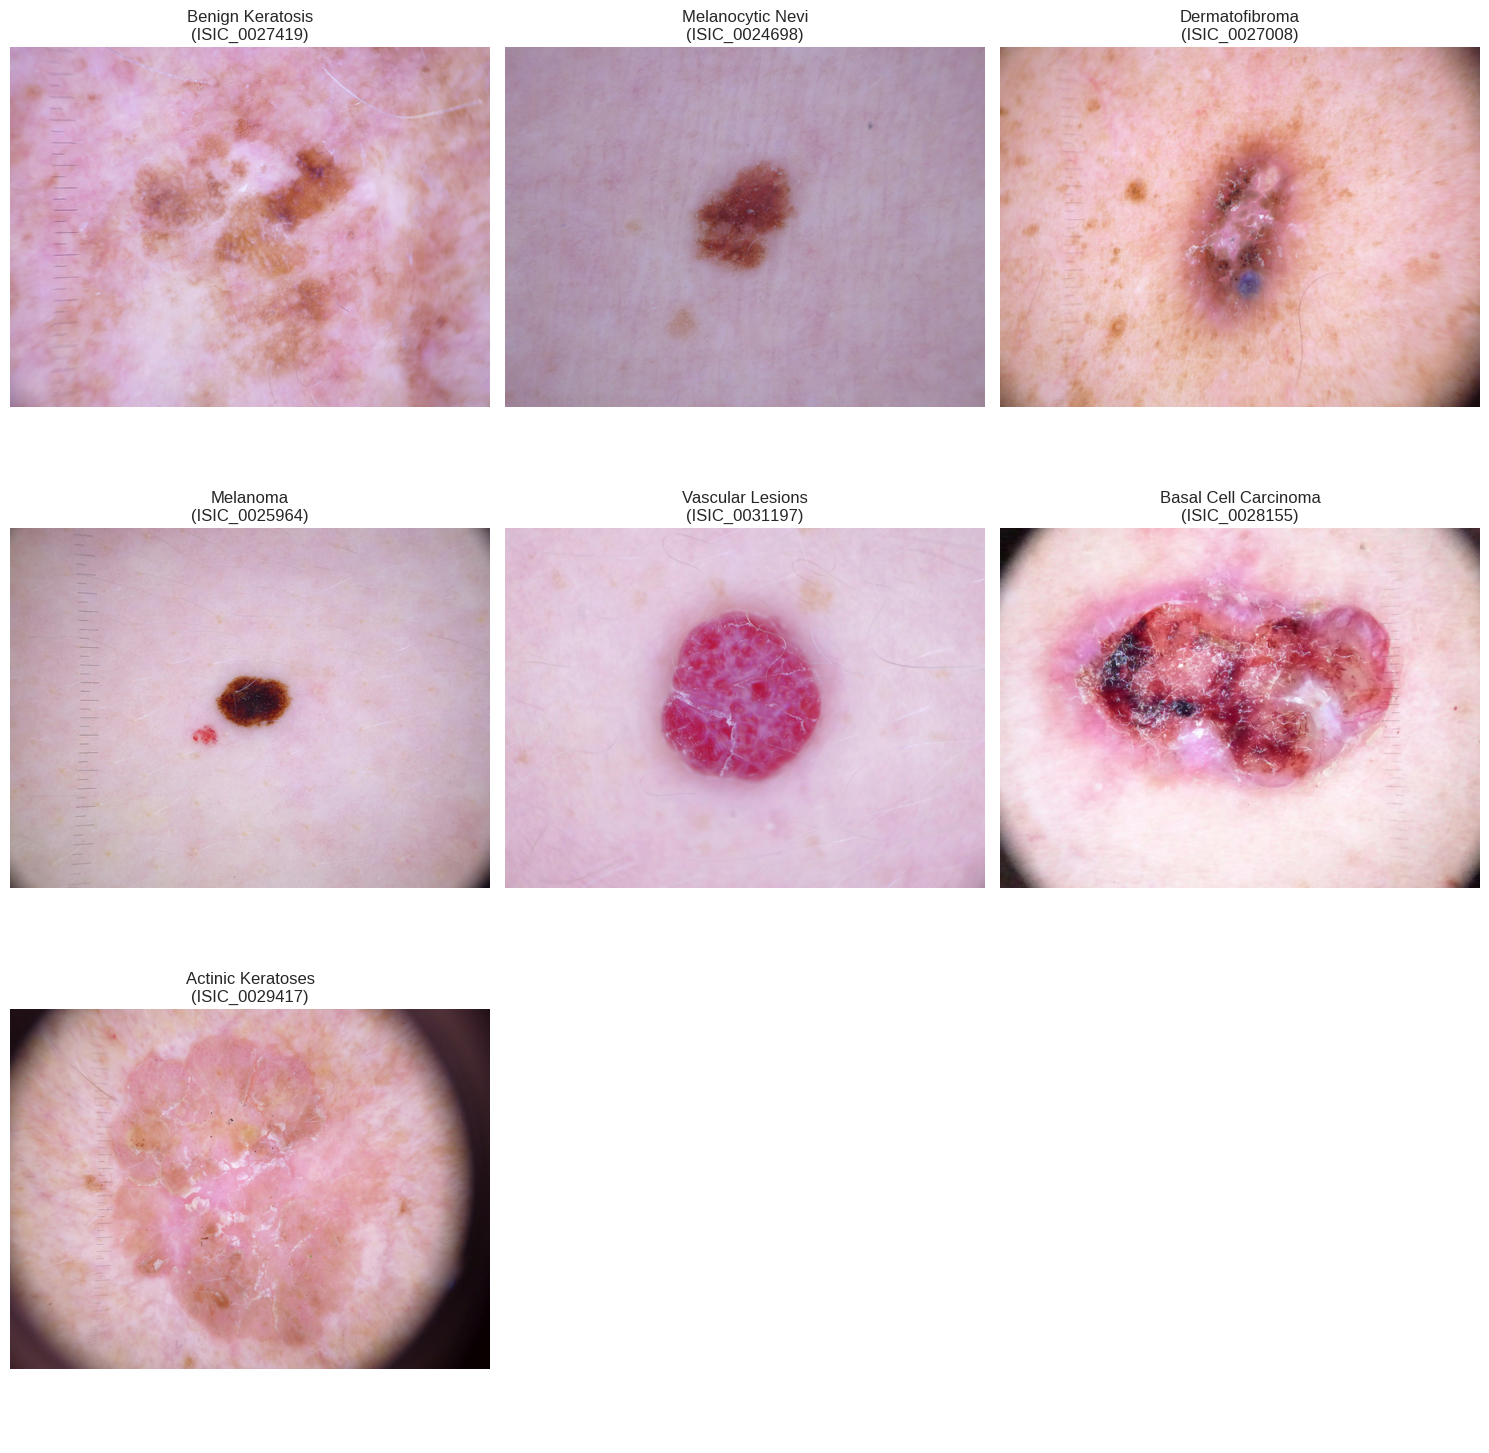

In [47]:
# Image Visualization
print("=== IMAGE VISUALIZATION ===")

# Display sample images
if sample_images:
    n_samples = len(sample_images)
    cols = 3
    rows = (n_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

    for i, (dx, img_id, img_path) in enumerate(sample_images):
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f'{diagnosis_mapping.get(dx, dx)}\n({img_id})')
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading\n{dx}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{dx} - Error')

    # Hide empty subplots
    for i in range(len(sample_images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No sample images could be loaded for visualization.")

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [49]:

metadata.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis_full,dx_type_full,age_group
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis,Histopathology,Elderly (70+)
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis,Histopathology,Elderly (70+)
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis,Histopathology,Elderly (70+)
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis,Histopathology,Elderly (70+)
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis,Histopathology,Elderly (70+)


In [50]:

# Combine both image folders
image_dir_1 = "/content/drive/MyDrive/ML&PR/HAM10000_images_part_1"
image_dir_2 = "/content/drive/MyDrive/ML&PR/HAM10000_images_part_2"

# Combine into one list of image paths
image_paths = []
for folder in [image_dir_1, image_dir_2]:
    for img_file in os.listdir(folder):
        if img_file.endswith(".jpg"):
            image_paths.append(os.path.join(folder, img_file))

# Build a dictionary of {filename: full_path}
path_dict = {os.path.basename(path): path for path in image_paths}



# Add full image paths to DataFrame
metadata['path'] = metadata['image_id'] + ".jpg"
metadata['path'] = metadata['path'].map(path_dict)

# Drop any rows where path wasn't found (if any)
df = metadata.dropna(subset=['path'])

# Optional: see class distribution
print(df['dx'].value_counts())


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [51]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['dx'],  # ensure class distribution is preserved
    random_state=42
)


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10
)

val_gen = ImageDataGenerator(rescale=1./255)


In [53]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [54]:
print(train_data.class_indices)


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


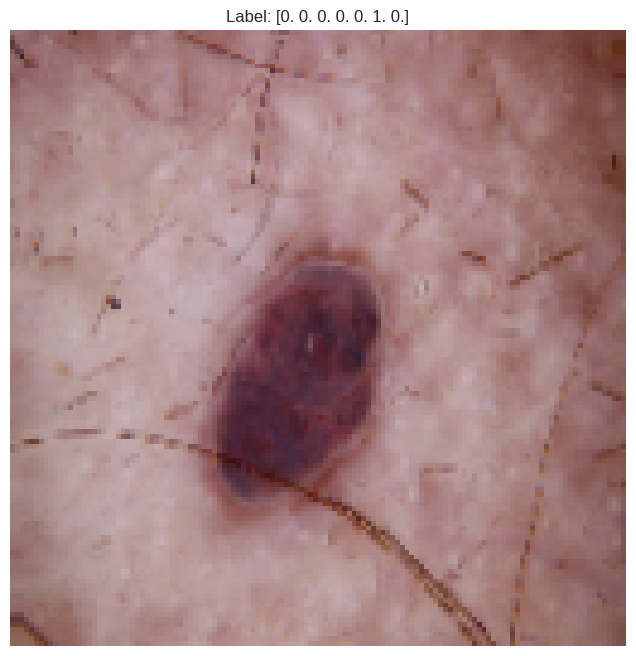

In [55]:
import matplotlib.pyplot as plt
images, labels = next(train_data)
plt.imshow(images[0])
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()


In [59]:
num_classes = len(train_data.class_indices)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [60]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
EPOCHS = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2396s 10s/step - accuracy: 0.6620 - loss: 1.1338 - val_accuracy: 0.6695 - val_loss: 0.9222
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.6647 - loss: 0.9663 - val_accuracy: 0.6715 - val_loss: 0.8370
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.6797 - loss: 0.8646 - val_accuracy: 0.7014 - val_loss: 0.8076
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.6958 - loss: 0.8255 - val_accuracy: 0.7084 - val_loss: 0.7791
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.6854 - loss: 0.8366 - val_accuracy: 0.7149 - val_loss: 0.7833
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.7033 - loss: 0.7864 - val_accuracy: 0.7099 - val_loss: 0.7802
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.7025 - loss: 0.7941 - val_accuracy: 0.7084 - val_loss: 0.7618
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.7076 - loss: 0.7798 - val_ac

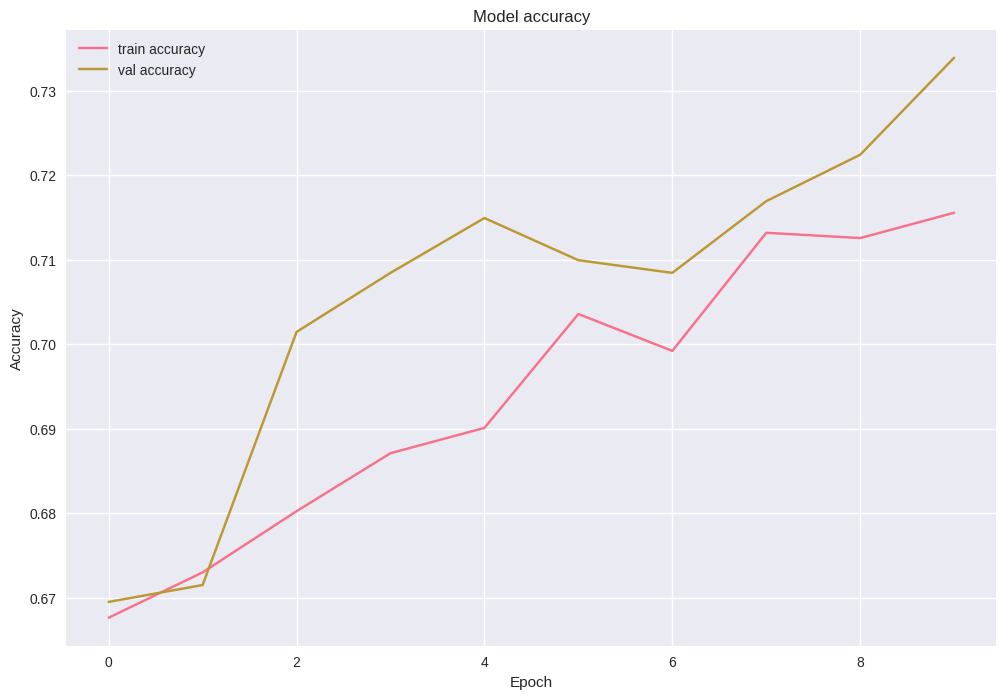

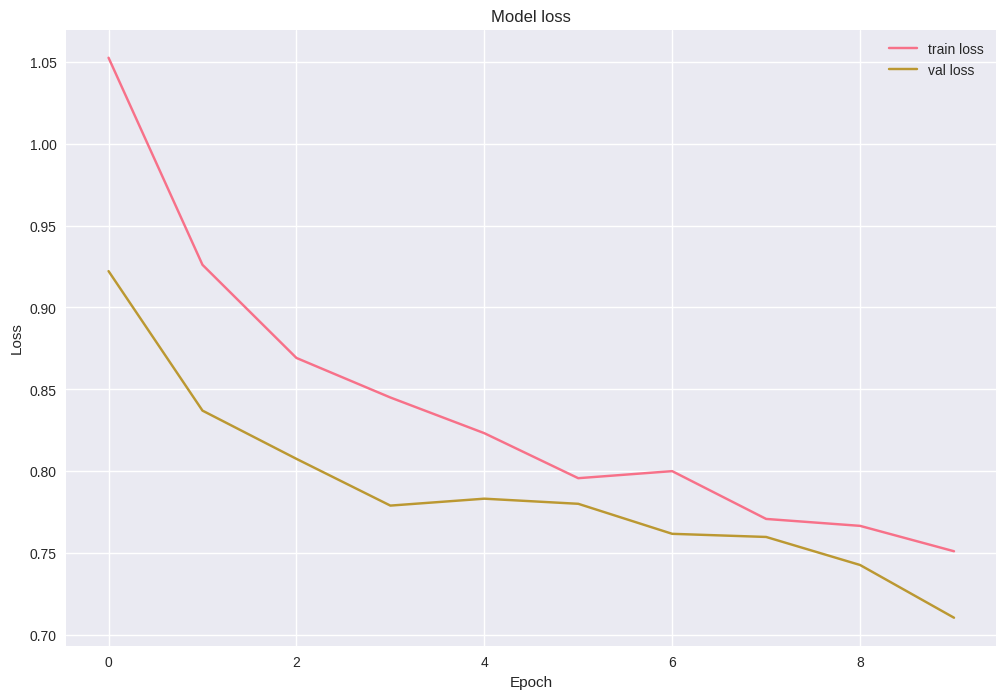

In [62]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 743ms/step
📊 Classification Report:
              precision    recall  f1-score   support

       akiec       0.06      0.03      0.04        65
         bcc       0.05      0.04      0.05       103
         bkl       0.07      0.05      0.06       220
          df       0.00      0.00      0.00        23
         mel       0.13      0.03      0.05       223
          nv       0.67      0.83      0.74      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.57      2003
   macro avg       0.14      0.14      0.13      2003
weighted avg       0.48      0.57      0.51      2003



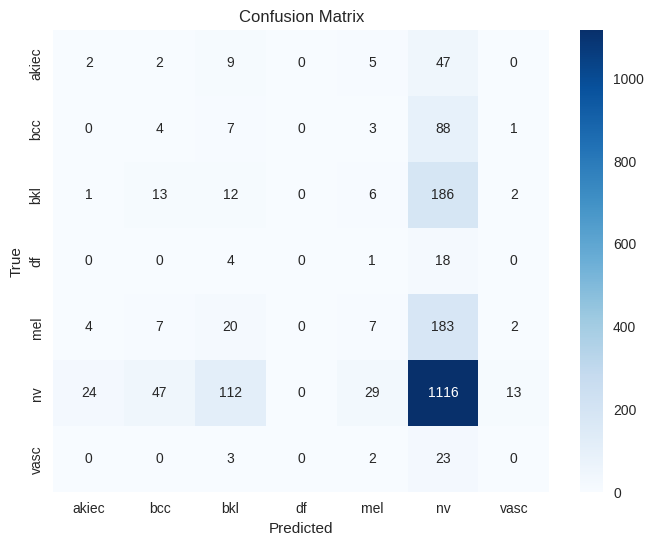

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions on validation set
val_preds = model.predict(val_data)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_data.classes

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=val_data.class_indices.keys(),
            yticklabels=val_data.class_indices.keys(),
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [65]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights using the correct column
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=train_df['dx']
)

# Map class labels to their index in the generator
label_to_index = train_data.class_indices
index_to_label = {v: k for k, v in label_to_index.items()}

# Create final class_weights dictionary using the correct index mapping
class_weights_dict = {
    label_to_index[label]: weight
    for label, weight in zip(np.unique(train_df['dx']), class_weights)
}

# ✅ Fit the model with weights
model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights_dict
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.4882 - loss: 1.7120 - val_accuracy: 0.4603 - val_loss: 1.4600
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.4463 - loss: 1.5180 - val_accuracy: 0.4953 - val_loss: 1.2393
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.4443 - loss: 1.4416 - val_accuracy: 0.5197 - val_loss: 1.2407
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.4338 - loss: 1.4587 - val_accuracy: 0.1573 - val_loss: 2.0501
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.2949 - loss: 1.5659 - val_accuracy: 0.5507 - val_loss: 1.2142
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.5035 - loss: 1.3674 - val_accuracy: 0.5696 - val_loss: 1.1434
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.5085 - loss: 1.3697 - val_accuracy: 0.5327 - val_loss: 1.1170
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.4874 - loss: 1.2565 - val_accu

In [66]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 539ms/step
📊 Classification Report (After Using Class Weights):
              precision    recall  f1-score   support

       akiec       0.03      0.05      0.04        65
         bcc       0.03      0.07      0.05       103
         bkl       0.09      0.04      0.05       220
          df       0.01      0.04      0.01        23
         mel       0.13      0.28      0.17       223
          nv       0.67      0.46      0.54      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.35      2003
   macro avg       0.14      0.13      0.12      2003
weighted avg       0.47      0.35      0.39      2003



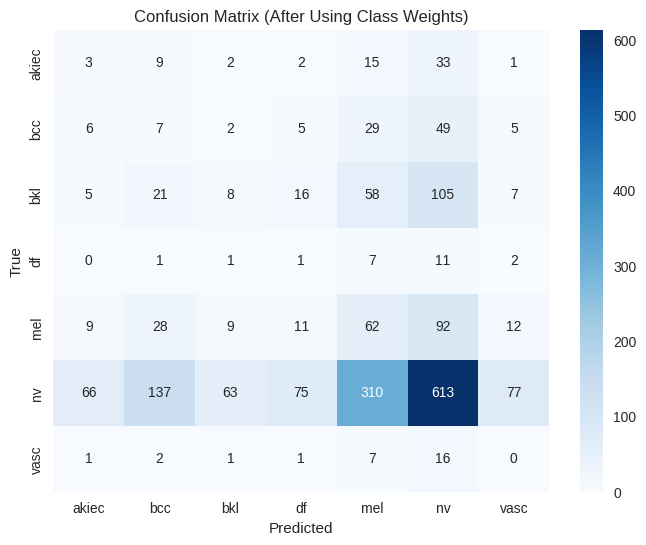

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
val_preds = model.predict(val_data)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_data.classes

# 📊 Classification report
print("📊 Classification Report (After Using Class Weights):")
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

# 🔷 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=val_data.class_indices.keys(),
            yticklabels=val_data.class_indices.keys(),
            cmap="Blues")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (After Using Class Weights)')
plt.show()


In [69]:
from sklearn.model_selection import train_test_split

# First split: Train+Val and Test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df['dx'],
    random_state=42
)

# Second split: Train and Validation from Train+Val
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['dx'],
    random_state=42
)


In [70]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for correct label order
)


Found 1002 validated image filenames belonging to 7 classes.


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 680ms/step
📊 Test Set Classification Report:
              precision    recall  f1-score   support

       akiec       0.17      0.27      0.21        33
         bcc       0.24      0.53      0.33        51
         bkl       0.28      0.11      0.16       110
          df       0.12      0.58      0.20        12
         mel       0.26      0.54      0.35       111
          nv       0.93      0.63      0.75       671
        vasc       0.21      0.79      0.33        14

    accuracy                           0.55      1002
   macro avg       0.32      0.49      0.33      1002
weighted avg       0.71      0.55      0.59      1002



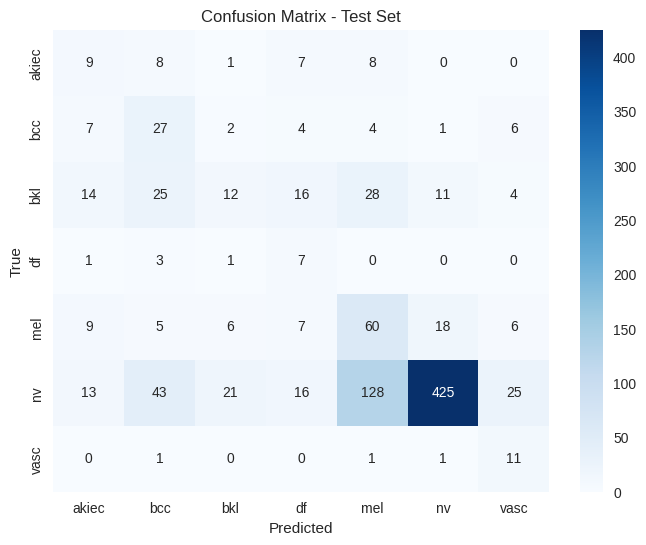

In [71]:
# Predict
test_preds = model.predict(test_data)
y_test_pred = np.argmax(test_preds, axis=1)
y_test_true = test_data.classes

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=test_data.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(),
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [68]:
model.save('cnn_skin_lesion_classifier.h5')
